           Age   Balance Kids Total_income Years_employed Car  \
0     0.324324       0.0  0.0     0.258721        0.28906   1   
1     0.310811  0.334031  0.0     0.055233        0.07217   0   
2     0.324324  0.636357  0.0     0.156977        0.19417   1   
3     0.283784       0.0  0.0     0.165698            0.0   0   
4     0.337838  0.500246  0.0     0.156977        0.04894   0   
...        ...       ...  ...          ...            ...  ..   
9704  0.054054       0.0  0.0     0.098837       0.012601   0   
9705  0.243243       0.0  0.0     0.055233        0.17145   0   
9706  0.162162       0.0  0.0     0.040698       0.109527   0   
9707  0.310811  0.459038  0.0     0.084302       0.084325   0   
9708  0.054054  0.444576  0.0     0.055233       0.075924   0   

     Education_type_Higher education Education_type_Incomplete higher  \
0                                  1                                1   
1                                  1                                1   


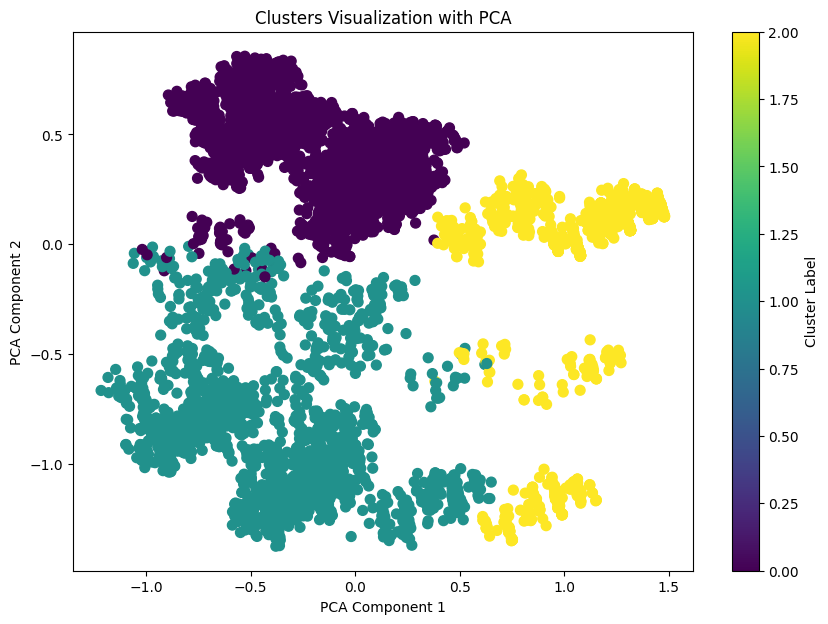

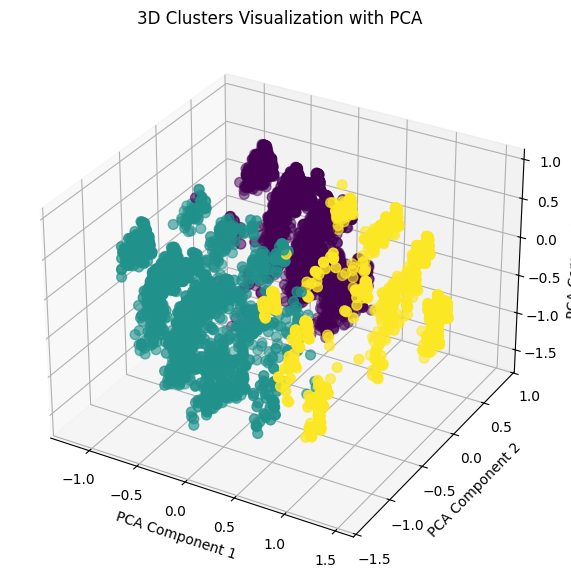

Cluster
0    0.239467
1    0.252648
2    0.265358
Name: Exited, dtype: object


In [24]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from scipy import stats
import numpy as np
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Load dataset into pandas dataframe
df = pd.read_csv('Summative Data.csv')

# Drop unnecessary column
df = df.drop(columns=['ID', 'Unemployed', 'Cr_score', 'Term_deposit', 'Target', 'Tenure', 'Credit_card', 'Acc_length'])  

# Normalise continuous variables 
normalize_columns = ['Age', 'Balance', 'Kids', 'Total_income', 'Years_employed']

# One-hot encode categorical variables (excluding churn label)
df = pd.get_dummies(df, drop_first=True)

# Define ColumnTransformer object with MinMaxScaler method for normalization
preprocessor = ColumnTransformer(
    transformers=[
        ('normalize', MinMaxScaler(), normalize_columns),  
    ],
    remainder='passthrough'  # Keep other columns unchanged (including the one-hot encoded columns)
)

# Use ColumnTransformer to create an array including normalised data 
df_transformed = preprocessor.fit_transform(df)

# Convert the array back to a DataFrame 
df_transformed = pd.DataFrame(df_transformed, columns=normalize_columns + df.columns.difference(normalize_columns).tolist())

# Remove outliers (rows containing numeric variables with Z-Scores > 3)
numeric_cols = df_transformed.select_dtypes(include=[np.number]) 
df_filtered = df_transformed[(np.abs(stats.zscore(numeric_cols)) < 3).all(axis=1)]  

"""# List to hold WCSS and silhouette scores
wcss = []
silhouette_scores = []

# Range of cluster values
k_values = range(2, 11)  # Start from 2 since silhouette score is not defined for k=1

# Loop over the k values
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_filtered)  # Using df_filtered for clustering
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS for the current k
    silhouette_avg = silhouette_score(df_filtered, cluster_labels)  # Calculate silhouette score
    silhouette_scores.append(silhouette_avg)  # Store the silhouette score

# Plotting the results
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot WCSS
ax1.plot(k_values, wcss, marker='o', color='b', label='WCSS')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('WCSS (Within-Cluster Sum of Squares)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid()

# Create a second y-axis for the silhouette scores
ax2 = ax1.twinx()
ax2.plot(k_values, silhouette_scores, marker='o', color='r', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add titles and legends
plt.title('Elbow Method and Silhouette Scores')
fig.tight_layout()  # To prevent overlap
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()"""

# Apply K-Means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(df_filtered)

# 5. Add the cluster labels back to the filtered DataFrame
df_filtered['Cluster'] = clusters

# Show the final DataFrame with cluster labels
print(df_filtered)

# Calculate the variance within each cluster
cluster_variances = df_filtered.groupby('Cluster').var()

# Display the variances for each cluster
print(cluster_variances)

# 1. Apply PCA to reduce the dataset to 2 components for visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_filtered.drop(columns=['Cluster']))  # Drop the 'Cluster' column before PCA

# 2. Create a scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df_filtered['Cluster'], cmap='viridis', s=50)

# 3. Add labels and title
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters Visualization with PCA')
plt.colorbar(label='Cluster Label')

# Show the plot
plt.show()
from mpl_toolkits.mplot3d import Axes3D

# Reduce to 3 components for 3D visualization
pca_3d = PCA(n_components=3)
df_pca_3d = pca_3d.fit_transform(df_filtered.drop(columns=['Cluster']))

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(df_pca_3d[:, 0], df_pca_3d[:, 1], df_pca_3d[:, 2], c=df_filtered['Cluster'], cmap='viridis', s=50)

# Add labels
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title('3D Clusters Visualization with PCA')

plt.show()

# Group by 'Cluster' and calculate the mean of 'Exited' for each cluster
prevalence = df_filtered.groupby('Cluster')['Exited'].mean()

# Display the prevalence
print(prevalence)



